## Calculating GDD to estimate planting date

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import datetime
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

#### 1961-1990

In [43]:
%%time 
warnings.filterwarnings(action='ignore')

# timing related settings
years = np.arange(1961, 1991) # timeframe in which we have weather data
dateparse = lambda dates: [datetime.datetime.strptime(d, "%Y%m%d%H") for d in dates] # dateparsing method to be used in pd.read_fwf
season_start, season_end = '02-01-', '6-30-' # setting a pretty borad range for growing season

# setting up np.read_fwf arguments
colnames = ['time', 'temp', 'temp_quality']
colspecs = [(15,25), (87,92), (92,93)]

# empty dataframes to store data from all site-years
df_temp_all = pd.DataFrame()

# reading in all weather data and storing as dataframe
for year in years:
    print(year) # output to track code progress
    times = pd.date_range(season_start + str(year), season_end + str(year) + ' 23:00:00', freq='1H')
    fnames = glob.glob('/home/disk/eos8/ach315/data/ISH/' + str(year) + '/*')
    
    # creating dataframes to store all site data for an individual year
    df_temp_sites = pd.DataFrame(index=times)
    
    for name in fnames:
        # WBAN site name 
        site_id = name.split('/')[-1].split('-')[-2]
        
        # read in individual files
        df = pd.read_fwf(name, names=colnames, colspecs=colspecs, header=None, index_col='time',
                         encoding='latin_1', dtype={'temp':int, 'precip':str}, 
                         parse_dates=True, date_parser=dateparse)
    
        # remove duplicated hours, keeping only the first measurement per hour
        df = df[df.index.duplicated(keep='first') == False]
        
        # add in missing time values (corrects for leap years) and keeps only growing season
        df = df.reindex(times, fill_value=np.nan)
                    
        # filtering out weather data based on quality code (data manual p.26)
        # removing data with code 3 (Erroneous) or 7 (Erroneous, data originate from an NCEI data source)
        # - temp
        quality_temp = (df.temp_quality=='3') | (df.temp_quality=='7')
        rows_temp = df[quality_temp].index
        df.loc[rows_temp, 'temp'] = np.nan

        # replacing missing data with NaN
        df.temp = df.temp.replace({9999: np.nan})
        
        # converting units 
        df.temp = df.temp/10
        
        # combining weather data into individual dataframes
        df_temp = pd.DataFrame({site_id: df.temp}, index= times)
        df_temp_sites = pd.concat([df_temp_sites, df_temp], axis= 1, sort=True)

    # combining all site-years data together
    df_temp_all = pd.concat([df_temp_all, df_temp_sites], sort=True)

#df_temp_all.to_csv('/home/disk/eos8/ach315/upscale/weadata/temp_6190_gdd.csv')

1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
CPU times: user 12min 48s, sys: 13.3 s, total: 13min 2s
Wall time: 14min 21s


#### 1991-2010

In [31]:
# reading in USAF site information - from solar radiation dataset
df_sites = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/stations_info_9110.csv')
df_sites.head()

# select only class 1 stations (see NSRDB manual p.7-8 for more details)
df_class1 = df_sites[(df_sites['CLASS'] == 1)]
sites_class1 = list(df_class1.USAF) # station list with class 1 quality

In [33]:
%%time

# timing related settings
years = np.arange(1991, 2011) # timeframe in which we have weather data
dateparse = lambda dates: [datetime.datetime.strptime(d, "%Y%m%d%H") for d in dates] # dateparsing method to be used in pd.read_fwf
season_start, season_end = '02-01-', '6-30-' # setting a pretty borad range for growing season

# setting up np.read_fwf arguments
colnames = ['time', 'temp', 'temp_quality']
colspecs = [(15,25), (87,92), (92,93)]

# empty dataframes to store data from all site-years
df_temp_all = pd.DataFrame()

# reading in all weather data and storing as dataframe
for year in years:
    print(year) # output to track code progress
    times = pd.date_range(season_start + str(year), season_end + str(year) + ' 23:00:00', freq='1H')
    
    # creating dataframes to store all site data for an individual year
    df_temp_sites = pd.DataFrame(index=times)
    
    for site in sites_class1:
        # selecting for file associated with specified site
        file = glob.glob('/home/disk/eos8/ach315/data/ISH/' + str(year) + '/' + str(site) + '-*')
        
        if len(file) == 0: # when specified site does not exist for current year
            continue # skip the following code and move on to the next site in the for loop
        elif len(file) == 1:
            name = file[0]
        else: # when specified USAF site has more than one WBAN ID, resulting in more than one unique site
            print('choosing from multiple files: ', file)
            name = glob.glob('/home/disk/eos8/ach315/data/ISH/' + str(year) + '/' + str(site) + '-99999-*')[0]
            # for cases when a USAF station ID is linked to two WBAN IDs, select the one in which WBAN is listed as 99999
            
        # reading in raw weather data as fixed-width data format
        df = pd.read_fwf(name, names=colnames, colspecs=colspecs, header=None, index_col='time',
                         encoding='latin_1', dtype={'temp':int, 'precip':str}, 
                         parse_dates=True, date_parser=dateparse)
        # remove duplicated hours, keeping only the first measurement per hour
        df = df[df.index.duplicated(keep='first') == False]

        # add in missing time values (corrects for leap years) and keeps only growing season
        df = df.reindex(times, fill_value=np.nan)
                
        # filtering out weather data based on quality code (data manual p.26)
        # removing data with code 3 (Erroneous) or 7 (Erroneous, data originate from an NCEI data source)
        # - temp
        quality_temp = (df.temp_quality=='3') | (df.temp_quality=='7')
        rows_temp = df[quality_temp].index
        df.loc[rows_temp, 'temp'] = np.nan

        # replacing missing values with NANs                    
        df.temp = df.temp.replace({9999: np.nan})

        # converting units 
        df.temp = df.temp/10

        # combining weather data into individual dataframes
        df_temp = pd.DataFrame({site: df.temp}, index= times)
        df_temp_sites = pd.concat([df_temp_sites, df_temp], axis= 1, sort=True)

    # combining all site-years data together
    df_temp_all = pd.concat([df_temp_all, df_temp_sites], sort=True)

#df_temp_all.to_csv('/home/disk/eos8/ach315/upscale/weadata/temp_9110_gdd.csv')

1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
choosing from multiple files:  ['/home/disk/eos8/ach315/data/ISH/2000/724665-93010-2000', '/home/disk/eos8/ach315/data/ISH/2000/724665-99999-2000']
2001
choosing from multiple files:  ['/home/disk/eos8/ach315/data/ISH/2001/724665-93010-2001', '/home/disk/eos8/ach315/data/ISH/2001/724665-99999-2001']
2002
choosing from multiple files:  ['/home/disk/eos8/ach315/data/ISH/2002/724665-99999-2002', '/home/disk/eos8/ach315/data/ISH/2002/724665-93010-2002']
2003
2004
2005
2006
2007
2008
2009
2010
choosing from multiple files:  ['/home/disk/eos8/ach315/data/ISH/2010/722045-12843-2010', '/home/disk/eos8/ach315/data/ISH/2010/722045-99999-2010']
choosing from multiple files:  ['/home/disk/eos8/ach315/data/ISH/2010/722146-12816-2010', '/home/disk/eos8/ach315/data/ISH/2010/722146-99999-2010']
choosing from multiple files:  ['/home/disk/eos8/ach315/data/ISH/2010/723183-13877-2010', '/home/disk/eos8/ach315/data/ISH/2010/723183-99999-2010']
choosing fro

### Merge two temp datasets

In [2]:
# read in weather data 1961-1990
df_temp_6190 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/temp_6190_gdd.csv', index_col=0)
# convert station ID header from WBAN to USAF (in order to make continuous with 1991-2010)
df_stations = pd.read_csv('/home/disk/eos8/ach315/data/ISH_NSRD/stations_wban_usaf.csv', header=None, dtype='str')
df_stations.columns = ['WBAN', 'USAF']
sites_wban = list(df_temp_6190.columns)
sites_usaf = df_stations[df_stations['WBAN'].isin(sites_wban)]['USAF']

# assign new USAF headers
df_temp_6190.columns = sites_usaf; df_temp_6190 = df_temp_6190.sort_index(axis=1)
print('1961-1990: ', df_temp_6190.shape)

# read in weather data 1991-2010
df_temp_9110 = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/temp_9110_gdd.csv', index_col=0)
print('1991-2010: ', df_temp_9110.shape)

# stitch two time periods together
df_temp = pd.concat([df_temp_6190, df_temp_9110], axis=0, join='outer'); df_temp = df_temp.sort_index(axis=1)
print('1961-2010: ', df_temp.shape)

1961-1990:  (108168, 237)
1991-2010:  (72120, 241)
1961-2010:  (180288, 274)


### Select valid siteyears (based on growing season)

In [70]:
# filter
df_summary = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/site_summary.csv', 
                         index_col=0, dtype={'site':str})
df_filtered = df_summary[(df_summary.area > 1000) & (df_summary.perct_irri < 50)] 

# how many site-years left?
df_siteyears = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_crithr2.csv', dtype='str', usecols=[1,2])
siteyears_filtered = df_siteyears[df_siteyears.site.isin(df_filtered.site)]
print('prior:', df_siteyears.shape[0])
print('filtered:', siteyears_filtered.shape[0]) 

prior: 4225
filtered: 3300


In [26]:
df_summary

,site,class,station,state,tzone,lat,lon,years,area,perct_irri
0,722010,1,KEY WEST INTL ARPT,FL,-5,24.550,-81.750,25,84670.9000,60.802507
1,722020,1,MIAMI INTL AP,FL,-5,25.817,-80.300,29,160227.6500,62.002065
2,722030,1,WEST PALM BEACH INTL ARPT,FL,-5,26.683,-80.100,19,145225.9500,78.435473
3,722050,1,ORLANDO INTL ARPT,FL,-5,28.433,-81.333,19,59312.4000,55.098924
4,722056,1,DAYTONA BEACH INTL AP,FL,-5,29.183,-81.067,19,23625.3000,50.088347
...,...,...,...,...,...,...,...,...,...,...
208,727910,1,ASTORIA REGIONAL AIRPORT,OR,-8,46.150,-123.883,20,14440.0500,17.981031
209,727920,1,OLYMPIA AIRPORT,WA,-8,46.967,-122.900,21,12942.4500,17.464643
210,727930,1,SEATTLE SEATTLE-TACOMA INTL A,WA,-8,47.467,-122.317,24,16192.4000,17.711657
211,727970,1,QUILLAYUTE STATE AIRPORT,WA,-8,47.933,-124.567,17,12377.4000,21.954267


In [5]:
siteyears_filtered.head()

,site,year
179,722060,1961
180,722060,1962
181,722060,1964
182,722060,1965
183,722060,1966


In [8]:
def calc_gdd(temps): 
    """
    - calculates GDH with base temperature = 8˚C
    - calculated values divided by 24 to correspond to daily values
    - function returns count of point in which gdd exceeds 100
      which can then be used to identify date in which GDD=100 is reached
    """
    gdd = 0
    for count, temp in enumerate(temps): 
        if gdd > 100: 
            break
        else:
            if temp-8 < 0:
                gdd += 0
            else:
                gdd += (temp-8)/24
    return(count)

In [86]:
pdates = []
doys = []

for i in np.arange(siteyears_filtered.shape[0]):
    site = siteyears_filtered.iloc[i,:].site
    year = siteyears_filtered.iloc[i,:].year
    df_temp_slice = pd.DataFrame(df_temp[str(year)+'-02-01':str(year)+'-06-30'][str(site)]).interpolate()
    temps = list(df_temp_slice.iloc[:,0])
    loc = calc_gdd(temps)
    pdate = list(df_temp_slice.index)[loc][:10]
    pdate = pd.to_datetime(pdate)
    doy = pdate.dayofyear
    pdates.append(pdate)
    doys.append(doy)

In [87]:
test = siteyears_filtered.copy()
test['pdate'] = pdates
test['doy'] = doys

In [88]:
test.head()

,site,year,pdate,doy
179,722060,1961,1961-02-18,49
180,722060,1962,1962-02-17,48
181,722060,1964,1964-02-21,52
182,722060,1965,1965-02-13,44
183,722060,1966,1966-02-18,49


In [99]:
df_filtered.head()

,site,class,station,state,tzone,lat,lon,years,area,perct_irri
5,722060,1,JACKSONVILLE INTL ARPT,FL,-5,30.500,-81.700,27,4978.0,10.089223
6,722070,1,SAVANNAH INTL AP,GA,-5,32.117,-81.200,22,8108.6,6.585904
7,722080,1,CHARLESTON INTL ARPT,SC,-5,32.900,-80.033,25,41559.4,5.152189
8,722110,1,TAMPA INTERNATIONAL AP,FL,-5,27.967,-82.533,8,50807.8,31.561666
9,722140,1,TALLAHASSEE REGIONAL AP [ISIS],FL,-5,30.400,-84.350,19,24496.7,13.348148


In [132]:
test[test.doy > 61]

,site,year,pdate,doy
185,722060,1968,1968-03-04,64
190,722060,1978,1978-03-08,67
217,722070,1978,1978-03-16,75
219,722070,1980,1980-03-04,64
226,722070,1993,1993-03-04,63
...,...,...,...,...
4130,727970,1991,1991-05-04,124
4131,727970,1992,1992-04-01,92
4132,727970,1993,1993-05-03,123
4133,727970,1994,1994-04-30,120


In [151]:
test[test.doy>61]

,site,year,pdate,doy
185,722060,1968,1968-03-04,64
190,722060,1978,1978-03-08,67
217,722070,1978,1978-03-16,75
219,722070,1980,1980-03-04,64
226,722070,1993,1993-03-04,63
...,...,...,...,...
4130,727970,1991,1991-05-04,124
4131,727970,1992,1992-04-01,92
4132,727970,1993,1993-05-03,123
4133,727970,1994,1994-04-30,120


In [147]:
df_latep = df_filtered[df_filtered.site.isin(set(test[test.doy > 61].site))]

Text(0.5, 1.0, 'GDD-based planting date')

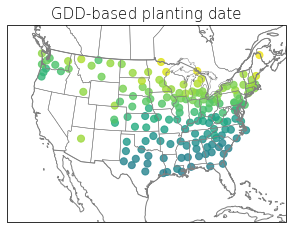

In [152]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1,
                     projection=ccrs.AlbersEqualArea(
                     central_latitude=39.5, central_longitude=-98.35))
ax.set_extent([-123,-72,19,53])
ax.scatter(df_latep.lon, df_latep.lat, s=50, transform=ccrs.PlateCarree(),
           vmin=0, vmax=150,
           c=list(test[test.doy>61].groupby('site').mean().doy), alpha=0.8)

ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax.set_title('GDD-based planting date', fontweight='light', fontsize=15)



Text(0.5, 1.0, 'GDD-based planting date')

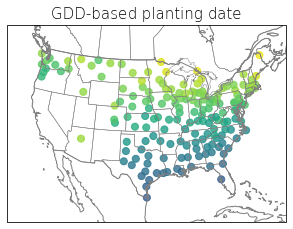

In [124]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1,
                     projection=ccrs.AlbersEqualArea(
                     central_latitude=39.5, central_longitude=-98.35))
ax.set_extent([-123,-72,19,53])
ax.scatter(df_filtered.lon, df_filtered.lat, s=50, transform=ccrs.PlateCarree(),
           vmin=0, vmax=150,
           c=list(test.groupby('site').mean().doy), alpha=0.8)

ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax.set_title('GDD-based planting date', fontweight='light', fontsize=15)

